The principle purpose of this project is to investigate whether there are any patterns to the types of species that become endangered. As an biodiveristy analyst for National Parks Service, the goal is to ensure the survival of at risk species. This would be done through maintaining the biodiveristy of the parks. Some questions that are raised in order to achieve this are:
1. What is the distribution of conservation_status for animals?
2. Are certain types of species more likely to be endangered?
3. Are the differences between species and their conservation status significant?
4. Which species were spotted the most at each park?

In [3]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns 
%matplotlib inline

In [4]:
observations = pd.read_csv('observations.csv', encoding = 'utf-8')
species_info = pd.read_csv('species_info.csv', encoding = 'utf-8')



### The observations DataFrame has the following columns:
- **scientific_name** - The scientific name of each species
- **park_name** - The name of the national park
- **observations** - The number of observations in the past 7 days

### The species_info DataFrame has the following columns:
- **category** - The category of taxonomy for each species
- **scientific_name** - The scientific name of each species
- **common_names** - The common names of each species
- **conservation_status** - The species conservation status

Let's explore the data further by seeing what the number of unique species are.

In [5]:
print('The number of unique species in the species_info dataset is: ', species_info.scientific_name.nunique())

The number of unique species in the species_info dataset is:  5541


Now, we want to see the number of categories items in the species_info categories column

In [6]:
print('The number of categories are ', species_info.category.nunique(), ', they are as follows: ', species_info.category.unique())

The number of categories are  7 , they are as follows:  ['Mammal' 'Bird' 'Reptile' 'Amphibian' 'Fish' 'Vascular Plant'
 'Nonvascular Plant']


In [7]:
print(species_info.groupby('category').size())

category
Amphibian              80
Bird                  521
Fish                  127
Mammal                214
Nonvascular Plant     333
Reptile                79
Vascular Plant       4470
dtype: int64


Vascular plants are by far the largest category in the data, with the smallest being Reptile closely followed by Amphibian.

We'll now explore the conservation status column. 

In [8]:
print('The number of unique values in the category column is ', species_info.conservation_status.nunique(), ', they are as follows: ', species_info.conservation_status.unique())

The number of unique values in the category column is  4 , they are as follows:  [nan 'Species of Concern' 'Endangered' 'Threatened' 'In Recovery']


In [9]:
print('The number of NaN values in the data set is ', species_info.conservation_status.isna().sum())

The number of NaN values in the data set is  5633


This figure means that there are 5633 species whose status is of no concern. Let's see about the others

In [10]:
species_info.groupby('conservation_status').size()

conservation_status
Endangered             16
In Recovery             4
Species of Concern    161
Threatened             10
dtype: int64

This data tells us that those in recovery are the fewest and those of concern are the greatest.

The number of parks and the names of the parks:

In [11]:
observations.park_name.nunique()
observations.park_name.unique()

array(['Great Smoky Mountains National Park', 'Yosemite National Park',
       'Bryce National Park', 'Yellowstone National Park'], dtype=object)

What are the total number of observations in the whole observations dataset?

In [12]:
print('The total number of observations made across all species is ', observations.observations.sum())

The total number of observations made across all species is  3314739


## Now let's perfom some analysis on our data...

First we will conver the NaN values in the conservation status row to 'No Concern'.

In [13]:
species_info.fillna('No Concern', inplace=True)
species_info.groupby('conservation_status').size()
species_info['is_protected'] = species_info['conservation_status'] != 'No Concern'

In [14]:
conservation_species = species_info[species_info.conservation_status != 'No Concern'].groupby(['conservation_status', 'category'])['scientific_name'].count().unstack()


By grouping the data by conservation_status and category, we can see that of the endagered species, there is 1 amphibian, 4 birds, 3 fish and 7 mammals. Of the in recovery species, there are 3 birds and 1 mammal. For the species of concern status, there are 72 birds and 28 mammals. These are by far the highest figures in the table. 

In order to be more precise with our conservation_status, I'll categorize the values. If the values are of no concern, the species is not protected. Any other category and they are considered protectd. 

In [15]:
species_info['is_protected'] = species_info.conservation_status != 'No Concern'


In [16]:
category_count = species_info.groupby(['category', 'is_protected'])\
                            .scientific_name.nunique().reset_index()\
                            .pivot(index='category', columns='is_protected', values='scientific_name').reset_index()

category_count.columns = ['category', 'not_protected', 'protected']
category_count['percent_protected'] = category_count.protected / (category_count.not_protected + category_count.protected) * 100
category_count

,category,not_protected,protected,percent_protected
0,Amphibian,72,7,8.860759
1,Bird,413,75,15.368852
2,Fish,115,11,8.730159
3,Mammal,146,30,17.045455
4,Nonvascular Plant,328,5,1.501502
5,Reptile,73,5,6.410256
6,Vascular Plant,4216,46,1.079305


The category with the highest number of protected species is mammals, followed by birds and then amphibians
Let's plot a barchat to visualize this

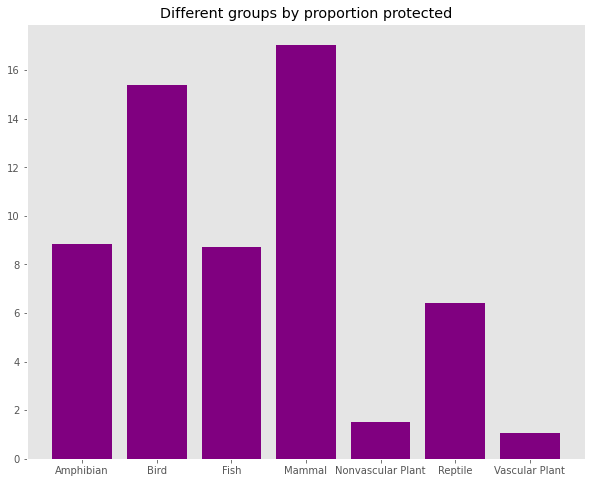

In [80]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.title('Different groups by proportion protected')
ax.bar(range(len(category_count.percent_protected)), category_count.percent_protected, color='Purple')
ax.set_xticks(range(len(category_count.percent_protected)));
ax.set_xticklabels(category_count.category)
ax.grid()
plt.show()

This plot shows us that the highest proportion of protected category are the mammals. The lowest being the vascular plants. 

Now we look at statistical significance to determine whether or not, with a significance threshold of 0.05, that mammals and birds are statistically significant. 

In [18]:
from scipy.stats import chi2_contingency
contingency1 = [[30, 146], [75, 413]]
chi2, pval, dof, expected = chi2_contingency(contingency1)
print('The p value is ', pval)

The p value is  0.6875948096661336


This p value is above 0.05 (our significane threshold) and therefore they are not significant. Let's now look at reptiles and mammals.

In [19]:

contingency2 = [[5, 73], [30, 146]]

chi2, pval, dof, expected = chi2_contingency(contingency2)
print('The p value is ', pval)


The p value is  0.03835559022969898


This is below our 0.05 threshold and therefore significant. The proportion of mammals that are protected is significantly higher than reptiles

We will now look at the observations made in the last 7 days across the four parks. 


In [20]:
species_info.head()

,category,scientific_name,common_names,conservation_status,is_protected
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,No Concern,False
1,Mammal,Bos bison,"American Bison, Bison",No Concern,False
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",No Concern,False
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Concern,False
4,Mammal,Cervus elaphus,Wapiti Or Elk,No Concern,False


Firstly, let's look at the distributions of each park. we can do so using a violin plot. 

Text(0.5, 1.0, 'The distribtuion of various park observations')

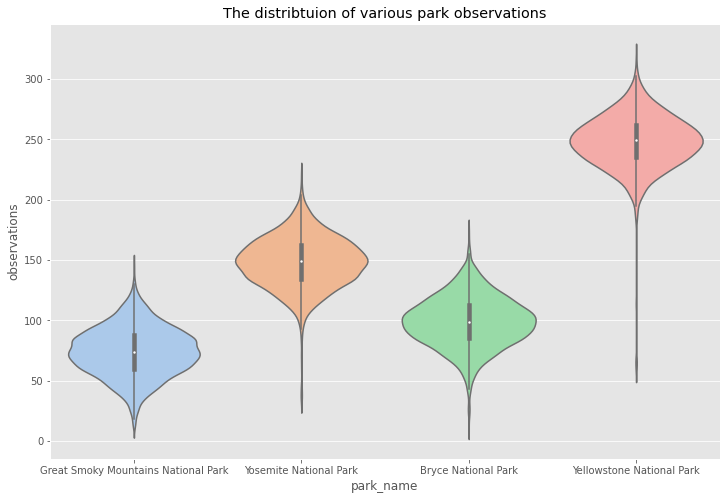

In [81]:
## plot violinplot
fig, ax = plt.subplots(figsize=(12, 8))
sns.violinplot(x = 'park_name', y = 'observations', data = observations, palette = 'pastel')
plt.title('The distribtuion of various park observations')


This data tells us that the Yellowstone National Park had the highest number of observations, whereas the Great Smoky Mountains National Park had the fewest observations in the last 7 days. All the parks have a similiar unimodal distribution. Let's find out which mammal species are most popular at each park 

In [22]:
species_info.head()
from itertools import chain
import string
def clean_punctuation(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text
names = species_info[species_info['category'] == 'Mammal'].common_names.apply(clean_punctuation).str.split().tolist()
clean_rows = []
for x in names:
    x = list(dict.fromkeys(x))
    clean_rows.append(x)

    
animal = list(chain.from_iterable(i if isinstance(i, list) else [i] for i in clean_rows))

#Now we have a list of each animal we can see which appear most frequently
words_counted = []
for i in animal:
    count = animal.count(i)
    words_counted.append((i, count))
    
animal_count = pd.DataFrame(set(words_counted), columns=['Animal', 'Count']).sort_values('Count', ascending=False)



Bat appears to appear the most frequently in common value names. Let's create a new column

In [23]:
species_info['is_bat'] = species_info.common_names.str.contains(r"\bBat\b", regex = True)

bats = species_info[species_info['is_bat']]
bats.common_names.nunique()


23

There are 23 species of bat across four parks. That's a lot of types of bat! Let's look at how they are observed by merging the observations data. 

In [43]:
bat_observations = observations.merge(bats)
bat_observations.groupby('park_name').observations.sum().reset_index()
bat_observations

,scientific_name,park_name,observations,category,common_names,conservation_status,is_protected,is_bat
0,Lasiurus blossevillii,Bryce National Park,113,Mammal,Western Red Bat,Species of Concern,True,True
1,Lasiurus blossevillii,Great Smoky Mountains National Park,70,Mammal,Western Red Bat,Species of Concern,True,True
2,Lasiurus blossevillii,Yosemite National Park,123,Mammal,Western Red Bat,Species of Concern,True,True
3,Lasiurus blossevillii,Yellowstone National Park,221,Mammal,Western Red Bat,Species of Concern,True,True
4,Corynorhinus rafinesquii,Yosemite National Park,188,Mammal,Rafinesque's Big-Eared Bat,No Concern,False,True
...,...,...,...,...,...,...,...,...
139,Myotis sodalis,Yellowstone National Park,68,Mammal,"Indiana Bat, Indiana Or Social Myotis",Endangered,True,True
140,Myotis leibii,Yosemite National Park,132,Mammal,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True
141,Myotis leibii,Bryce National Park,84,Mammal,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True
142,Myotis leibii,Great Smoky Mountains National Park,49,Mammal,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True


The park with the most bats is the Yellowstone national park. This park also had the highest number of general observations. Either it is a larger park than the others or it has greater biodiveristy. Let's compare the bats in different parks, seeing whether or not they are protected. 

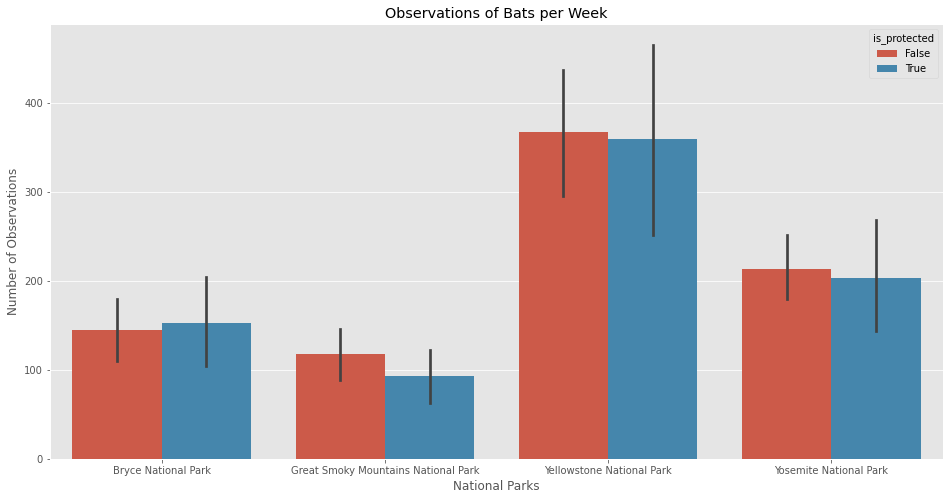

In [83]:
observation_park = bat_observations.groupby(['common_names', 'is_protected', 'park_name']).observations.sum().reset_index()
plt.style.use('ggplot')
plt.figure(figsize=(16, 8))
sns.barplot(x=observation_park.park_name, y= observation_park.observations, hue=observation_park.is_protected)
plt.xlabel('National Parks')
plt.ylabel('Number of Observations')
plt.title('Observations of Bats per Week')
plt.show()

The Yellowstone National Park has the best cnservation of bats, those both protected as well as not protected. All the parks except Bryce National Park have a higher number of protected bats than non-protected bats.  

In [44]:
bats_ranked = bat_observations.sort_values('observations', ascending=False)

Here, the most common bat is the Little Brown Bat. Let's see which park bats are most commonly found at. 


In [48]:
bats_by_park = bat_observations.groupby('park_name').sum().reset_index()
bats_by_park

,park_name,observations,is_protected,is_bat
0,Bryce National Park,3433,20,36
1,Great Smoky Mountains National Park,2411,20,36
2,Yellowstone National Park,8362,20,36
3,Yosemite National Park,4786,20,36


Clearly, the most common park for bats is the Yellowstone National park, let's visualize this data with a barchart.

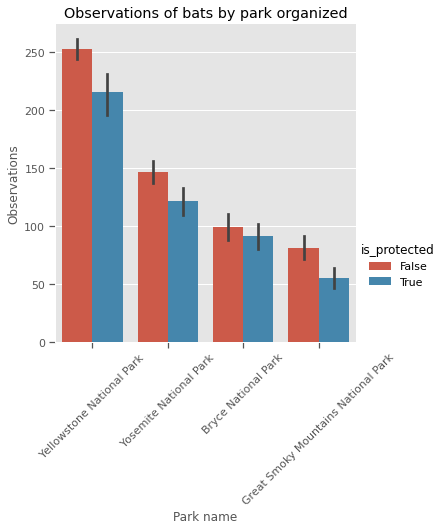

In [92]:
park_names = ['Yellowstone National Park', 'Yosemite National Park', 'Bryce National Park', 'Great Smoky Mountains National Park']
sns.set_context('notebook')
sns.set_palette('Purples')
plt.style.use('ggplot')
ax = sns.catplot(kind = 'bar', data = bat_observations, x = 'park_name', y = 'observations', order=park_names, hue = 'is_protected');
plt.xlabel('Park name')
plt.ylabel('Observations')
plt.title('Observations of bats by park organized')
ax.set_xticklabels(park_names, rotation = 45);
plt.show()



This plot tells us that that the Yellowstone National Park has almost twice as many observations as the next, Yosemite National Park. We can see clearly also the distinction between those protected and those non protected bats, with those not protected making up the greater share of the observation sum for each park. 

## Conclusions

The data provided insights into the species that exist in four parks across the United States. Althought he observations data was only the past 7 days, it would be more helpful to have more recent data collected. Although the following conclusions were drawn. 

### What is the distribution of conservation_status for animals?

There were 191 species in conservation and 5,633 species who are of no concen with regards to their consevation status. There were 16 endangered species, 4 in recovery, 10 threated and 161 species of concern.
                  
### Are certain types of species more likely to be endangered?

Mammals and Birds had the highest number of endangered species. The lowest were vascular plants.

### Are the differences between species and their conservation status significant?

My calculations suggest a statistically different conservation status between mammals reptiles however none between mammals and birds. 

### Which species were spotted the most at each park?

The most commonly obserced species were bats. They were most likely to be seen at Yellowstone National Park. 